# L-DOPA Synthesis in _E. coli_: Review, Analysis, and Future Directions
#### Russell O. Stewart
#### ENGS 161
#### 20W
#### Final Project

# Road Map

* Introduction
    * Background
    * Previous Synthetic Attempts
* Resources and Methods
* Analysis
    * Black Box Stoichiometry
    * Flux Balance Analysis
    * Balance Sanity Check
    * Thermodynamics
* Conclusions and Future Directions
    * Re-Evaluation of Previous Synthetic Attempts
    * Future Directions

# Background

# L-DOPA, Derivatives and their Pharmacologic Applications

![Image](external_figures/l_dopa_derivatives.png)

L-DOPA: Stimulatory monoamine neurotransmitter. Basis of other very important monoamines, like dopamine, and glucocorticoids, like epinephrine and norepinephrine.

In humans: biosynthesized from tyrosine. Tyrosine itself is synthesized from phenylalanine, which is an essential amino acid. (I.E: Humans cannot synthesize L-DOPA _de novo_.)

L-DOPA and derivatives have many pharmacological applications. L-DOPA is used in the treatment of Parkinson's Disease. Norepinephrine, as a glucocorticoid, is used to rapidly raise blood pressure in patients with sepsis. Epinephrine is used to treat anaphalaxyis and cardiac arrest (think epi pens!)

Standard way to make L-DOPA, patented by Monsanto, is asymmetric hydrogenation. However, the enantioselectivity of this is apparently pretty garbage, making the process quite inefficient.

# Synthesis in _E. coli_: The Shikimate Pathway
![Image](external_figures/Shikimate-pathway-modified-from-Bentley-1990-Schmid-and-Amrhein-1995.png)

Unlike humans, autotrophs and some particularly independent heterotrophs like _E. Coli_ can synthesize all 3 aromatic amino acids _de novo_. They do so through the shikimate pathway.

Needed inputs: E4P (we can get this through the PPP) and PEP (we can get this through glycolysis)

# The Final Step: hpaBC

![Image](External_Figures/hpaBC_patent.png)

_(US patent 06/014.1587A1)_

# Previous Biosynthetic Attempts in _E. coli_

# Munoz et al, 2011: $Y_{ldopa/gluc}=0.074\ cmol/cmol$
![Image](external_figures/munoz_shikimate_pathway.png)

Key Edits

* Introduce galP in place of PEP-dependent glucose transport
* Knock out tyrR, which exerts product feedback control on much of shikimate pathway
* Extra, inducible copy of hpaBC
* Feedback-insensitive chorismate mutase/prephenate dehydrogenase (same enzyme)

# Wei et al, 2016: $Y_{ldopa/gluc}=0.086\ cmol/cmol$
![Image](external_figures/wei_synthetic_pathway.png)

Key Edits Beyond Munoz

* Knock out oxidative pentose phosphate pathway
* Knock out csrA, which does negative feedback inhibition in TCA cyle
* Knock out pheLA to prevent phenylalanine synthesis
* Multiplexed automated genome engineering: edit RBS'es, swap codons (to remove RNA-level control) in shikimate pathway enzymes (also transketolase)

# Resources and Methods

![Image](figures/bigg_map.png)

# Black-Box Stoichiometry

* **_What is the maximum theoretical yield of L-DOPA from glucose?_**
* **_What are feasible sources of nitrogen for our synthesis?_**

Obtain a stoichiometric matrix $S$ of glucose, L-DOPA, and $H_2O$, $NH_3$, and $CO_2$

Define our flux vector $q$

$Sq=0$

$q_{calc}=-S_{calc}^{-1}S_{meas}q_{meas}$

Measured flux: glucose (-1). Unmeasured fluxes: all others.

# Stoichiometric Matrix

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
S = pd.read_excel('exchange_stoichiometries.xls' , index_col = 0)
print('Stoichiometric Matrix')
display(S)

Stoichiometric Matrix


,co2,for,glc,glu,h,h2o,o2,levdopa,nh4
c,1,1,6,5,0,0,0,9,0
h,0,1,12,8,1,2,0,11,4
o,2,2,6,4,0,1,2,4,0
n,0,0,0,1,0,0,0,1,1


# Glucose as Carbon Source, Ammonia as Nitrogen Source

In [29]:
S_meas = S[['glc']]
S_calc = S[['h2o','nh4','levdopa','co2']]
S_calc.at['h','nh4'] = 3#Use ammonia, not ammonium!
S_calc.columns = ['h2o','nh3','levdopa','co2']
v_meas = pd.DataFrame(np.array([-1]) , index = ['glc'])
v_calc = -1* np.linalg.inv(S_calc) @ S_meas @ v_meas
v_calc.index = ['h2o','nh3','levdopa','co2']
v_calc.columns = ['Flux']
v_calc

,Flux
h2o,3.333333
nh3,-0.666667
levdopa,0.666667
co2,0.000000


$3\ Glucose + 2\ NH_3 \rightarrow 10\ H_2O + 2\ levdopa$.

$Y_{ldopa/glu}=0.667\ mol/mol=1\ cmol/cmol$

$Y_{ldopa/NH3}=1\ mol/mol$

# Glucose as Carbon Source, Glutamate as Nitrogen Source

In [37]:
S_meas = S[['glc']]
S_calc = S[['h2o','glu','levdopa','co2']]
S_calc.at['h','glu'] = S_calc.at['h','glu'] + 1#Use glutamic acid, not glutamate!
S_calc.columns = ['h2o','glu','levdopa','co2']
v_meas = pd.DataFrame(np.array([-1]) , index = ['glc'])
v_calc = -1* np.linalg.inv(S_calc) @ S_meas @ v_meas
v_calc.index = ['h2o','glu','levdopa','co2']
v_calc.columns = ['Flux']
v_calc

,Flux
h2o,4.666667
glu,-1.333333
levdopa,1.333333
co2,0.666667


$3\ Glucose + 4\ Glu \rightarrow 2\ CO_2 + 14\ H_2O + 4\ levdopa$.

$Y_{ldopa/glu}=1.33\ mol/mol$

$Y_{ldopa/total\ carbon\ input}=0.947\ cmol/cmol$

$Y_{ldopa/glu}=1\ mol/mol$

# Summary: Maximum Yields from Black Box Stochiometry
![Image](figures/blackbox.png)

# Flux Balance Analysis

* **_On which pathways will this synthesis depend?_**
* **_Does our maximum yield drop at all?_**
* **_Does this inform our growth conditions?_**

Run flux balance analysis using `cobra`, and display our results using `escher`

In [6]:
#load up everything
%matplotlib inline
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()
import escher
from escher import Builder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import cobra.test
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,double_reaction_deletion)

network = pd.read_csv('shikimate_reactions.csv' , header=0)#shikimate related reactions to add
sinks = pd.read_csv('sinks.csv' , header=0)#sinks to add

levdopa_synthesis = cobra.io.load_json_model("e_coli_core.json")#e coli central metabolism model from BiGG
#levdopa_synthesis.solver = 'cplex'

#define intracellular reactions not in central metabolism model
for (myenzyme , mypathway , myreaction) in network.itertuples(index = False):
    rxn = Reaction(myenzyme)
    levdopa_synthesis.add_reactions([rxn])
    rxn.name = myenzyme
    rxn.subsystem = mypathway
    rxn.build_reaction_from_string(myreaction)

#define extra transport reactions not in central metabolism model
for (mymetabolite , mydirection) in sinks.itertuples(index = False):
    myreaction = '%s -->' % mymetabolite
    rxn = Reaction('EX_%s' % mymetabolite)
    levdopa_synthesis.add_reactions([rxn])
    rxn.subsystem = 'Extracellular exchange'
    rxn.name = '%s_transport' % mymetabolite
    rxn.build_reaction_from_string(myreaction)
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.

unknown metabolite 'dahp_c' created
unknown metabolite 'dhq_c' created
unknown metabolite '3dhs_c' created
unknown metabolite 'shikimate_c' created
unknown metabolite 'shikimate3p_c' created
unknown metabolite 'epsp_c' created
unknown metabolite 'chorismate_c' created
unknown metabolite 'prephenate_c' created
unknown metabolite '4hppa_c' created
unknown metabolite 'tyr__L_c' created
unknown metabolite 'levdopa_c' created
unknown metabolite 'levdopa_e' created


In [7]:
levdopa_synthesis.objective = 'EX_levdopa_e'#maximize L-DOPA production
builder = Builder(map_json = 'full_map.json')
builder.model = levdopa_synthesis
builder.highlight_missing = True
solution = builder.model.optimize()
builder.reaction_data = solution.fluxes/ abs(solution['EX_glc__D_e'])
Y_ldopa_glc = solution['EX_levdopa_e']/abs(solution['EX_glc__D_e'])
Y_ldopa_nh4 = solution['EX_levdopa_e']/abs(solution['EX_nh4_e'])
print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from ammonia: %f mol/mol' % Y_ldopa_nh4)

Yield of levdopa from glucose: 0.508230 mol/mol; 0.762345 cmol/cmol
Yield of levdopa from ammonia: 1.000000 mol/mol


# Aerobic FBA Solution
![Image](Escher_Maps/aerobic_fba.png)

# Aerobic, with Rich Media

_What if both glutamate and ammonia are free to be used as nitrogen sources?_

In [8]:
import copy
levdopa_synthesis_with_glutamate = copy.deepcopy(levdopa_synthesis)
#allow glutamate to be used as a feedstock
levdopa_synthesis_with_glutamate.reactions.EX_glu__L_e.lower_bound = -1000
builder_glutamate = Builder(map_json = 'full_map.json')
builder_glutamate.model = levdopa_synthesis_with_glutamate
builder_glutamate.highlight_missing = True
solution_glutamate = builder_glutamate.model.optimize(objective_sense = None)
builder_glutamate.reaction_data = solution_glutamate.fluxes / abs(solution_glutamate['EX_glc__D_e'])
Y_ldopa_glc = solution_glutamate['EX_levdopa_e']/abs(solution_glutamate['EX_glc__D_e'])
Y_ldopa_glu = solution_glutamate['EX_levdopa_e']/abs(solution_glutamate['EX_glu__L_e'])
pct_carbon_assimilated = solution_glutamate['EX_levdopa_e'] * 9 / abs(solution_glutamate['EX_glc__D_e'] * 6 + solution_glutamate['EX_glu__L_e'] * 5)
print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from glutamate: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glu , 9/5*Y_ldopa_glu))
print('Percent of carbon from both glucose and glutamate into L-DOPA: %f cmol/cmol' % pct_carbon_assimilated)

Yield of levdopa from glucose: 15.442448 mol/mol; 23.163672 cmol/cmol
Yield of levdopa from glutamate: 0.312127 mol/mol; 0.561829 cmol/cmol
Percent of carbon from both glucose and glutamate into L-DOPA: 0.548525 cmol/cmol


# Rich Media FBA Solution
![Image](Escher_Maps/glutamate_fba.png)

# Anaerobic Fermentation

In [10]:
levdopa_synthesis_anaerobic = copy.deepcopy(levdopa_synthesis)
#knock out oxygen intake
levdopa_synthesis_anaerobic.reactions.O2t.knock_out()
builder_anaerobic = Builder(map_json = 'full_map.json')
builder_anaerobic.model = levdopa_synthesis_anaerobic
builder_anaerobic.highlight_missing = True
solution_anaerobic = builder_anaerobic.model.optimize(objective_sense = None)
builder_anaerobic.reaction_data = solution_anaerobic.fluxes / abs(solution_anaerobic['EX_glc__D_e'])
Y_ldopa_glc = solution_anaerobic['EX_levdopa_e']/abs(solution_anaerobic['EX_glc__D_e'])
Y_ldopa_nh4 = solution_anaerobic['EX_levdopa_e']/abs(solution_anaerobic['EX_nh4_e'])
print('Yield of levdopa from glucose: %f mol/mol; %f cmol/cmol' % (Y_ldopa_glc , 9/6*Y_ldopa_glc))
print('Yield of levdopa from ammonia: %f mol/mol' % Y_ldopa_nh4)

Yield of levdopa from glucose: -0.000000 mol/mol; -0.000000 cmol/cmol
Yield of levdopa from ammonia: nan mol/mol


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14 RuntimeWarning: invalid value encountered in double_scalars


# Anaerobic FBA Solution
![Image](Escher_Maps/anaerobic_fba.png)

# Summary: Maximum Yields by Analytical Paradigm
![Image](figures/blackboxvsfba.png)

# Balance Sanity Check

* **_Before we head on to thermodynamics, do our flux balance analysis solutions obey black box atom balances?_**

A valid flux solution $q$ will satisfy $Sq=0$, where $S$ is the species stoichiometric matrix.

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#Read in csv
solution = pd.read_csv('FBA_results/aerobic.csv' , index_col = 0)
solution_glu = pd.read_csv('FBA_results/aerobic_glutamate.csv' , index_col = 0)
#Extract the exchange fluxes
solution_exchanges = solution[solution.index.str.contains('EX_')]
solution_glu_exchanges = solution_glu[solution_glu.index.str.contains('EX_')]
#FBA returned some fluxes that are near-zero but not zero because of double roundoff errors.
solution_exchanges = solution_exchanges.query('abs(fluxes) > .0000000001')
solution_glu_exchanges = solution_glu_exchanges.query('abs(fluxes) > .0000000001')
#Convert the indexes into just the species name, without EX_ or _e
solution_index = [re.search(r"_[^_]+_{1}",i).group() for i in solution_exchanges.index]
solution_index = [i[1:len(i)-1] for i in solution_index]
solution_exchanges.index = solution_index
solution_glu_index = [re.search(r"_[^_]+_{1}",i).group() for i in solution_glu_exchanges.index]
solution_glu_index = [i[1:len(i)-1] for i in solution_glu_index]
solution_glu_exchanges.index = solution_glu_index
#Read in stoichiometries of our exchanged metabolites
S = pd.read_excel('exchange_stoichiometries.xls' , index_col = 0)

In [13]:
print('Stoichiometric Matrix')
display(S)
print('Aerobic Solution Exchange Fluxes (mM/min)')
display(solution_exchanges.T)
print('Aerobic + Glutamate Solution Exchange Fluxes (mM/min)')
display(solution_glu_exchanges.T)

Stoichiometric Matrix


,co2,for,glc,glu,h,h2o,o2,levdopa,nh4
c,1,1,6,5,0,0,0,9,0
h,0,1,12,8,1,2,0,11,4
o,2,2,6,4,0,1,2,4,0
n,0,0,0,1,0,0,0,1,1


Aerobic Solution Exchange Fluxes (mM/min)


,co2,glc,h,h2o,nh4,o2,levdopa
fluxes,14.259281,-10.0,5.082302,39.670791,-5.082302,-14.259281,5.082302


Aerobic + Glutamate Solution Exchange Fluxes (mM/min)


,co2,for,glc,glu,h,h2o,nh4,o2,levdopa
fluxes,659.676219,484.244776,-10.0,-494.748259,-350.827264,442.30209,340.323781,-654.424478,154.424478


# Aerobic Solution Element Balance

In [27]:
display(S[solution_exchanges.index] @ solution_exchanges)

,fluxes
c,-4.440892e-15
h,-4.174439e-14
o,-7.105427e-15
n,0.000000e+00


# Rich Media Solution Element Balance

In [26]:
display(S[solution_glu_exchanges.index] @ solution_glu_exchanges)

,fluxes
c,7.105427e-13
h,1.222134e-12
o,-1.136868e-13
n,8.526513e-14


# Thermodynamics

* **_Are our two aerobic FBA solutions spontaneous? How do their_** $\Delta G^{'}_m$ **_compare?_**

* **_Can we use minimum driving force analysis with_** `equilibrator_pathway` **_to pinpoint bottlenecks and steps amenable to flux control?_**

In [22]:
#load up everything
%matplotlib inline
import cobra
from cobra import Model, Reaction, Metabolite
cobra_config = cobra.Configuration()
import escher
from escher import Builder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import cobra.test
import equilibrator_api
from equilibrator_api import Q_
from equilibrator_api import get_compound
import math
from sbtab import SBtab
from equilibrator_pathway import Pathway

network = pd.read_csv('shikimate_reactions.csv' , header=0)#shikimate related reactions to add
sinks = pd.read_csv('sinks.csv' , header=0)#sinks to add

levdopa_synthesis = cobra.io.load_json_model("e_coli_core.json")#e coli central metabolism model from BiGG
#levdopa_synthesis.solver = 'cplex'

#define intracellular reactions not in central metabolism model
for (myenzyme , mypathway , myreaction) in network.itertuples(index = False):
    rxn = Reaction(myenzyme)
    levdopa_synthesis.add_reactions([rxn])
    rxn.name = myenzyme
    rxn.subsystem = mypathway
    rxn.build_reaction_from_string(myreaction)

#define extra transport reactions not in central metabolism model
for (mymetabolite , mydirection) in sinks.itertuples(index = False):
    myreaction = '%s -->' % mymetabolite
    rxn = Reaction('EX_%s' % mymetabolite)
    levdopa_synthesis.add_reactions([rxn])
    rxn.subsystem = 'Extracellular exchange'
    rxn.name = '%s_transport' % mymetabolite
    rxn.build_reaction_from_string(myreaction)
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.

solution = pd.read_csv('FBA_results/aerobic.csv' , index_col = 0)
solution_glutamate = pd.read_csv('FBA_results/aerobic_glutamate.csv' , index_col = 0)

unknown metabolite 'dahp_c' created
unknown metabolite 'dhq_c' created
unknown metabolite '3dhs_c' created
unknown metabolite 'shikimate_c' created
unknown metabolite 'shikimate3p_c' created
unknown metabolite 'epsp_c' created
unknown metabolite 'chorismate_c' created
unknown metabolite 'prephenate_c' created
unknown metabolite '4hppa_c' created
unknown metabolite 'tyr__L_c' created
unknown metabolite 'levdopa_c' created
unknown metabolite 'levdopa_e' created


In [23]:
#Import e coli core model in json format
with open('e_coli_core.json') as f:
    ecolicore = json.load(f)
metabolites = ecolicore['metabolites']

custom_metabolites = pd.read_csv('shikimate_metabolites.csv' , index_col = 0)

#Returns KEGG ID for a given BiGG ID
def getKEGG(met_id):
    #Search for metabolite by BiGG ID in the e coli core model
    entry = list(filter(lambda met: met['id'] == met_id, metabolites))
    #If we get a hit, return it
    try:
        return entry[0]['annotation']['kegg.compound'][0]
    #If else, it's probably one of my custom metabolites
    except:
        return custom_metabolites.at[met_id , 'KEGG_ID']
    

#Takes a reaction object and converts it into an Equilibrator-parsable string
def stringReaction(rxn , for_pathway = False):
    left = {met : stoich for met , stoich in rxn.metabolites.items() if stoich < 0}
    right = {met : stoich for met , stoich in rxn.metabolites.items() if stoich > 0}
    rxn_string = ''
    
    if not for_pathway:
        for met , stoich in left.items():
            rxn_string += '%.2f kegg:%s + ' % (-1*stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '= '
        for met , stoich in right.items():
            rxn_string += '%.2f kegg:%s + ' % (stoich , getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    else:
        #return in equilibrator pathway-happy format if you so request. (no kegg or leading 1's)
        for met , stoich in left.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (-1*stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string)-2] + '<=> '
        for met , stoich in right.items():
            if abs(stoich) != 1:
                rxn_string += '%.2f %s + ' % (stoich , getKEGG(met.id))
            else:
                rxn_string += '%s + ' % (getKEGG(met.id))

        rxn_string = rxn_string[0:len(rxn_string) - 3]
    return(rxn_string)
#Gets delta go or delta gm for each reaction in a data frame
def getG(flux_df , useGm = False):
    #this will store the string form g values and the indices in parallel arrays
    g = []
    indices = []
    #iterate over every reaction that isn't an exchange or transport
    for rxn in flux_df.index:
        if rxn.rfind('EX_') < 0 and rxn.rfind('_t') < 0 and rxn != 'H2Ot' and rxn != 'NH4t' and rxn != 'CO2t' and rxn != 'O2t':
            #flip the signs of reactions with negative fluxes
            if flux_df.loc[rxn , 'fluxes'] < 0:
                flip_sign = -1
            else:
                flip_sign = 1
            try:
                #make equilibrator model of reaction
                s = stringReaction(levdopa_synthesis.reactions.get_by_id(rxn))
                reaction = equilibrator_api.parse_reaction_formula(s)
                cc = equilibrator_api.ComponentContribution(p_h=Q_(7.0), temperature=Q_("298.15K"))
                # calculate standard free energy
                if not useGm:
                    g.append(flip_sign * cc.standard_dg_prime(reaction))
                #calculate metabolic free energy
                else:
                    g.append(flip_sign * cc.physiological_dg_prime(reaction))
            except:
                print('Failed to add reaction %s' % rxn)
                g.append(None)
            indices.append(rxn)
    #extract magnitudes and errors from string form g
    magnitudes = []
    errors = []
    for a in g:
        if a is None:
            magnitudes.append(None)
            errors.append(None)
        else:
            magnitudes.append(float(str(a.magnitude)[0:str(a.magnitude).rfind('+')]))
            errors.append(float(str(a.magnitude)[str(a.magnitude).rfind('-')+1:]))
    #return result as data frame
    if useGm:
        cols = ['dGm_kJ_per_mol' , 'error']
    else:
        cols = ['dGo_kJ_per_mol' , 'error']
    result = pd.DataFrame(zip(magnitudes , errors) , index = indices , columns = cols)
    return result

# Overall Pathway Thermodynamics

Calculate the $\Delta G^{'}_{m}$ of each step in a given flux solution using `equilibrator`

Multiply this $\Delta G^{'}_{m}$ (in kJ/mol) by the corresponding step flux (in mol/min, arbitrary units here)

Sum these scaled $\Delta G^{'}_{m}$ to get an overall value for the pathway

Divide by the flux of L-DOPA synthesis so that we can compare FBA solutions more fairly

## Aerobic Solution

In [24]:
Gm = getG(solution , useGm = True)
nonspontaneous = Gm.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous = Gm.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')
dGm_overall = 0
for index , row in Gm.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall += row['dGm_kJ_per_mol'] * abs(solution.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall) / abs(solution.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution
Total dGm of flux vector: -8916.193232 kJ/min
Normalized to L-DOPA production: -1754.361105 kJ/mol L-DOPA


## Rich Media Aerobic Solution

In [31]:
print('Aerobic Solution with Glutamate Feed')
Gm_glu = getG(solution_glutamate , useGm = True)
nonspontaneous_glu = Gm_glu.query('dGm_kJ_per_mol > 0').sort_values(by='dGm_kJ_per_mol' , ascending = False)
spontaneous_glu = Gm_glu.query('dGm_kJ_per_mol <= 0').sort_values(by='dGm_kJ_per_mol')
dGm_overall_glu = 0
for index , row in Gm_glu.iterrows():
    if not math.isnan(row['dGm_kJ_per_mol']):
        dGm_overall_glu += row['dGm_kJ_per_mol'] * abs(solution_glutamate.loc[index , 'fluxes'])
print('Total dGm of flux vector: %f kJ/min' % dGm_overall_glu)
print('Normalized to L-DOPA production: %f kJ/mol L-DOPA' % (float(dGm_overall_glu) / abs(solution_glutamate.loc['EX_levdopa_e' , 'fluxes'])))

Aerobic Solution with Glutamate Feed
Total dGm of flux vector: -300455.460008 kJ/min
Normalized to L-DOPA production: -1945.646601 kJ/mol L-DOPA


# Minimum Driving Force Analysis

Determine the minimum driving force-optimized species concentrations and reaction $\Delta G^{'}$ using `equilibrator_pathway`

In [32]:
#Export solution as an Equilibrator Pathway-compatible CSV file
def makeCSV(flux_df , filename):
    reaction_names = [stringReaction(levdopa_synthesis.reactions.get_by_id(rxn) , for_pathway = True) for rxn in flux_df.index]
    result = pd.DataFrame(zip(reaction_names , flux_df.fluxes.values), columns = ['ReactionFormula' , 'RelativeFlux'])
    result.to_csv('Equilibrator_Pathway_CSV/%s' % filename , index = False)
#Run this function for the shikimate pathway. Only put in the rows that aren't sinks or passive transports.
shikimate_rxns = [r.name for r in levdopa_synthesis.reactions if r.subsystem == 'shikimate_pathway' or r.subsystem == 'tyrosine_metabolism']
shikimate_fluxes = solution.loc[shikimate_rxns,'fluxes'] / solution.loc['hpaBC','fluxes']
shikimate_rxns = pd.DataFrame(shikimate_fluxes.values , index = shikimate_rxns , columns = ['fluxes'])
#Only worry about the NADH-dependent shikimate dehydrogenase for this analysis.
shikimate_rxns = shikimate_rxns.drop(['shikimate_dh'])
shikimate_rxns.at['shikimate_dh_nadh','fluxes'] = 1
makeCSV(shikimate_rxns , 'shikimate.csv')
#Make CSV files for the aerobic and aerobic+glutamate FBA solutions (scrub out sinks and passive transports)
exchange_reactions = ['EX_for_e','EX_pi_e','PIt2r','EX_co2_e','FORti','EX_glc__D_e','EX_h_e','EX_h2o_e','EX_nh4_e','EX_o2_e','CO2t','NH4t','H2Ot','O2t','levdopa_t','EX_levdopa_e','EX_glu__L_e','GLUt2r']
makeCSV(solution.query('not index in @exchange_reactions')  , 'solution.csv')
makeCSV(solution_glutamate.query('not index in @exchange_reactions')  , 'solution_glutamate.csv')

*__brief detour to the equilibrator website to make an `sbtab`__*

# The Shikimate Pathway Alone

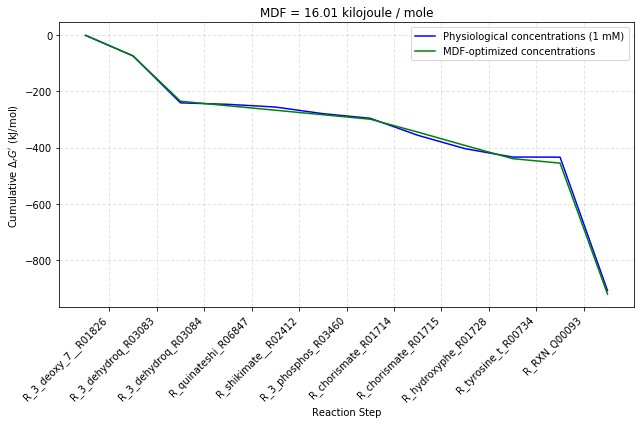

In [34]:
filename = 'Equilibrator_Pathway_CSV/shikimate_pH7.00_I0.10_MDF.tsv'#Read in resulting sbtab
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("shikimate_pH7.00_I0.10_MDF", file_content, filename)#Run mdf analysis
shikimate_pathway = Pathway.from_sbtab(doc)
shikimate_mdf_result = shikimate_pathway.calc_mdf()#Plot output
shikimate_mdf_result.reaction_plot;

# Aerobic Solution

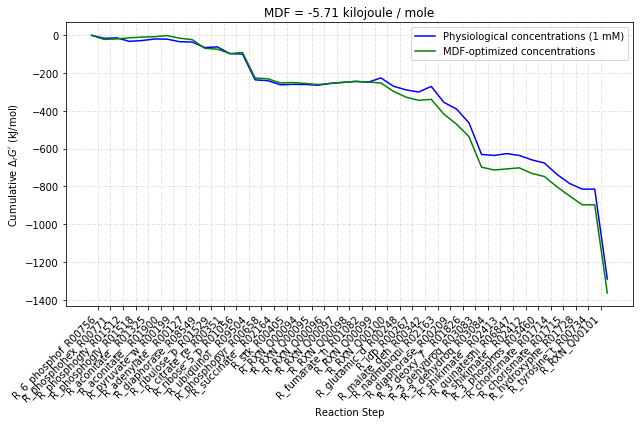

In [35]:
filename = 'Equilibrator_Pathway_CSV/solution_pH7.00_I0.10_MDF.tsv'#Read in resulting sbtab
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_pH7.00_I0.10_MDF", file_content, filename)#Run mdf analysis
solution_pathway = Pathway.from_sbtab(doc)
solution_mdf_result = solution_pathway.calc_mdf()#Plot output
solution_mdf_result.reaction_plot;

# Rich Media Solution

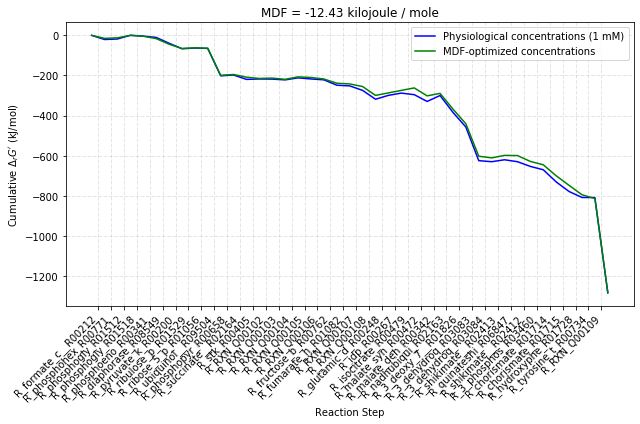

In [36]:
filename = 'Equilibrator_Pathway_CSV/solution_glutamate_pH7.00_I0.10_MDF.tsv'#Read in resulting sbtab
sbtab_file = open(filename, 'r')
file_content = sbtab_file.read()
sbtab_file.close()
doc = SBtab.SBtabDocument("solution_glutamate_pH7.00_I0.10_MDF", file_content, filename)#Run mdf analysis
solution_glu_pathway = Pathway.from_sbtab(doc)
solution_glu_mdf_result = solution_glu_pathway.calc_mdf()#Plot output
plt = solution_glu_mdf_result.reaction_plot;

# Conclusions

* __*How do the Wei et al. and Munoz et al. attempts compare to our maximum theoretical yields?*__
* __*Are Wei's and Munoz's genome engineering choices rational?*__
* __*What other enzymes could be manipulated to further imporve yield?*__